In [151]:
# Let's start by importing the libraries we will need below.

from google.colab import drive
drive.mount('/content/drive', force_remount=True)

import math
import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt

import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf

import sys
sys.path.append('/content/drive/MyDrive/Colab Notebooks/April')  # Here is the location of my stock historical database.
from pipelines import loaders, filters, interpolators  # Import my own data pipelines.

print("Imported Libraries")

Mounted at /content/drive
Imported Libraries


In [61]:
# Let's choose from a number of stocks to get a good feel for our EDA.
# For argument's sake let's select two of the highest and two of the lowest performing stocks in 2021.
# However, depending on your strategy you might weight trades higher depending on 
# positive momentum, market cap, or trade volume.

tickers = ['AAPL', 'AMD', 'WYNN', 'ETSY']
yf_filepath = '/content/drive/MyDrive/Colab Notebooks/April/data/yf'
columns = ['Date', 'Open', 'High', 'Low', 'Close', 'Volume']  # We will request OHLCV data from our database.

# We will load our historicals in as a dict, with each key being a ticker string and with values as a pandas dataframe.
historicals = loaders.load_historicals(tickers, columns, yf_filepath) 
display(historicals['AAPL'].head())  # Let's see an example of our loaded historicals.

,Open,High,Low,Close,Volume
Date,,,,,
2007-01-22,2.729483,2.730096,2.622619,2.657526,1.454026e+09
2007-01-23,2.625068,2.679571,2.618331,2.624149,1.207424e+09
2007-01-24,2.654158,2.668550,2.635786,2.654771,9.278136e+08
2007-01-25,2.667324,2.709886,2.634254,2.640991,9.059736e+08
2007-01-26,2.667324,2.675285,2.602409,2.614351,9.868740e+08


###1. Basic Returns


In [149]:
# Starting with the basic returns transformation as stated earlier in the readme.md file of the repository.

def transform_by_daily_returns(historicals):
  '''Transforms historical OHLCV data to their daily returns.

  Daily percent returns are calculated with the equation (P2/P1)-1.
  Where P2 is the OHLCV data for the current day and P1 is the OHLCV data.
  A (-1) is added to the equation to help center the mean around 0 
  for analysis later. See "_calculate_daily_returns(ohlcv)" for calculation 
  details.
  
  Args:
    historicals: dict with tickers as keys and values
                 as pandas dataframes.

  Returns:
    historicals_by_returns: dict with tickers as keys and values
                            as pandas dataframes with calculated
                            daily returns.
  '''

  historicals_by_returns = {}
  for ticker, ohlcv in historicals.items():
    historicals_by_returns[ticker] = _calculate_daily_returns(ohlcv)
  return historicals_by_returns

def _calculate_daily_returns(ohlcv):
  '''Calculates daily returns for the given stock history.'''
  daily_returns = ((ohlcv / ohlcv.shift(1)) - 1) * 10  # Add a (-1) to center the mean around 0.
  shifted_index = daily_returns.index[1:]  # Shift index forward so returns line up with their current date.
  daily_returns = daily_returns.dropna()
  daily_returns.index = shifted_index
  return daily_returns

historicals_by_returns = transform_by_daily_returns(historicals)
display(historicals_by_returns['AMD'].head())  # Let's take a quick look at one of the daily returns below.

,Open,High,Low,Close,Volume
Date,,,,,
2007-01-23,0.005685,0.034014,0.063732,-0.011410,0.345501
2007-01-24,-0.772728,-0.706215,-0.829016,-0.845231,19.451565
2007-01-25,-0.061576,-0.024317,0.043942,0.012475,-5.859504
2007-01-26,0.006196,-0.085313,0.006250,0.105919,-0.728915
2007-01-29,0.037152,-0.024586,-0.099937,-0.166461,0.485348


count    1703.000000
mean        0.016968
std         0.376100
min        -2.834113
25%        -0.162657
50%         0.005945
75%         0.195104
max         3.060012
Name: Close, dtype: float64

Skewness is 0.54749995470047
Kurtosis is 9.946845054626465



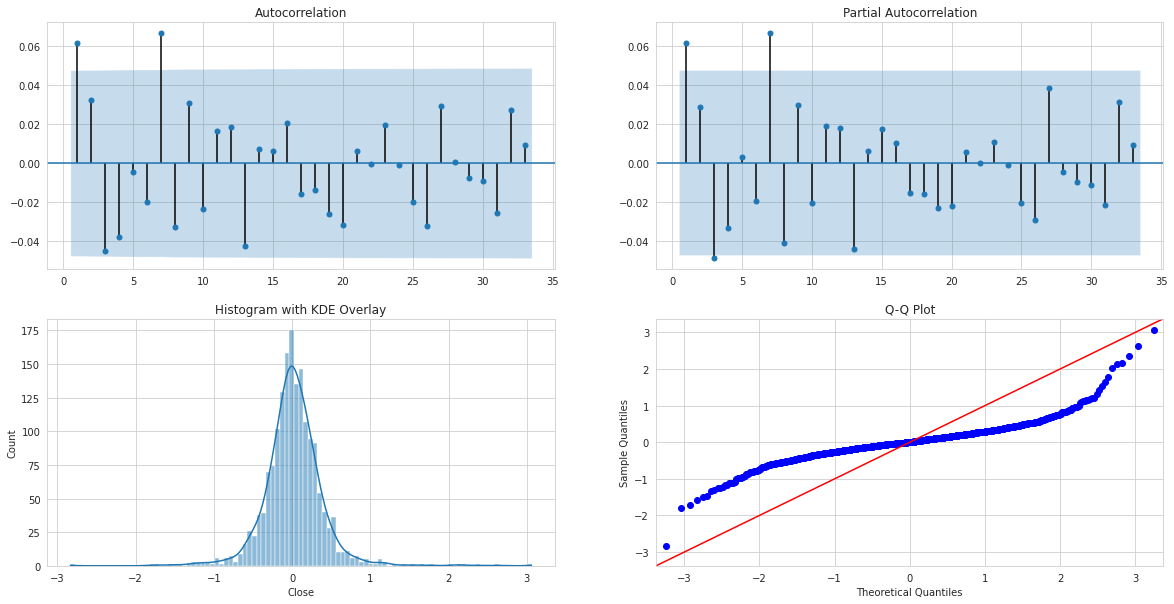

In [159]:
# Let's calculate the statistical properties of the basic returns data and some typical statistical graphs.

def plot_stationary_graphs(price_history):
  '''Prints the data's statistical properties and a collection of stationary graphs.

  Included graphs are as follows:
  1. ACF Plot
    - Autocorrelation Function Plot describes relations between a value
      and its past values. Checks for stationarity and a constant mean / variance.
  2. PACF Plot
    - Partial Autocorrelation Function Plot is similar to an ACF Plot but 
      removes correlations between the shorter lags. Checks for stationarity 
      and a constant mean / variance.
  3. Histogram Plot with Kernel Density Estimation
    - For visualization of the distribution of the data.
  4. Q-Q Plot
    - Quantile-Quantile Plot comparing our data's distribution on
      the sample quantiles axis against a normal distribution on
      the theoretical quantiles. If the data lines up on the center 
      y=x line, the data follows a normal distribution.

  Args:
    price_history: pandas series or array of a single price history column.

  Returns:
    None
  '''

  print(price_history.describe())
  print('\nSkewness is {}'.format(price_history.skew()))
  print('Kurtosis is {}\n'.format(price_history.kurtosis()))

  %matplotlib inline
  figure_dims = (20, 10)
  fig, ax = plt.subplots(2,2, figsize=figure_dims)
  sns.set_style('whitegrid')

  ax[0][0] = plot_acf(price_history, zero=False, ax=ax[0][0])
  ax[0][1] = plot_pacf(price_history, zero=False, ax=ax[0][1])

  ax[1][0] = sns.histplot(data=price_history, kde=True, ax=ax[1][0])
  ax[1][0].title.set_text('Histogram with KDE Overlay')

  sm.qqplot(price_history, line='45', ax=ax[1][1])
  ax[1][1].title.set_text('Q-Q Plot')
  plt.show()

plot_stationary_graphs(historicals_by_returns['ETSY']['Close'])  # Run and examine the visualizations.
                                                                 # You can run the other tickers or OHLC data for yourself (they all look similar).

In [ ]:
# A normal distribution can be described by having the following statistical properties:
# Mean = 0, standard deviation = 1, skew = 0, and a kurtosis = 3.
# There are two statsitical properties above that differ greatly from a normal distribution.
# This is the low standard deviation (0.037) and the high kurtosis (9.94) compared to the gaussian normal.
# The term black swan events in trading can be seen here with high kurtosis causing both the
# Q-Q plot and the normal distribution to have long (fat) tails at the end. Additionally, the
# low standard deviation causes the majority of data points to be spread around the mean.
# The majority of trading strategies profit off the events that happen often with the clumping
# of the data points around the mean, but otherwise will get blown out by a black swan event
# due to the high kurtosis. Again, our goal here is to identify and avoid trading during black swan 
# events and attempt to profit off the center statistical attributes. Let's keep going and record what we find.

###2. Log Returns

count    1703.000000
mean        0.009944
std         0.374573
min        -3.332533
25%        -0.163994
50%         0.005943
75%         0.193225
max         2.669699
Name: Close, dtype: float64

Skewness is -0.10238330066204071
Kurtosis is 9.822844505310059



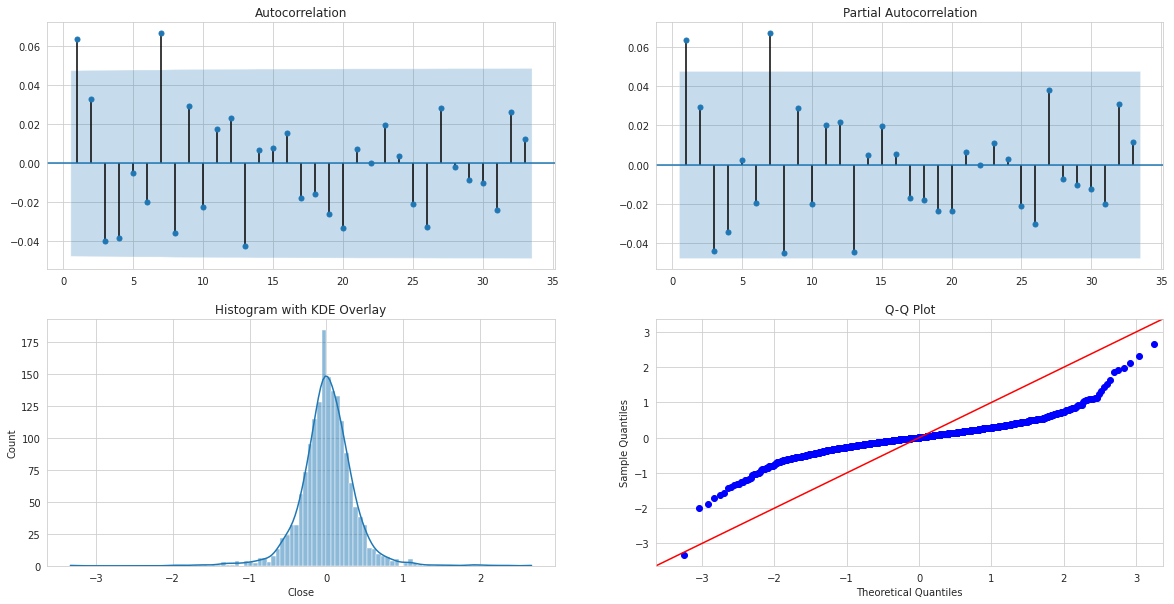

In [163]:
# Two log transformations to check here, base e and base 10

def transform_by_log_returns(historicals, base=math.e):
  '''Transforms historical ohlcv to their daily change percents.

  Daily percent changes are calculated by with the equation log(P2/P1)*100.
  Where P2 is the OHLCV data for the current day and P1 is the OHLCV data
  for the previous day, see "_calculate_daily_returns(ohlcv)."
  
  Args:
    historicals: dict with tickers as keys and values
                 as pandas dataframes.
    base: integer, {math.e, 10}. Defaults math.e.

  Returns:
    historicals_by_returns: dict with tickers as keys and values
                            as pandas dataframes.
  
  Raises:
    AssertionError: "Specified log base is not avaliable. Please choose one: {math.e, 10}."
  '''

  assert base in [math.e, 10], "Specified log base is not avaliable. Please choose one: {math.e, 10}."

  historicals_by_logs = {}
  for ticker, ohlcv in historicals.items():
    historicals_by_logs[ticker] = _calculate_log_returns(ohlcv, base)
  return historicals_by_logs

def _calculate_log_returns(ohlcv, base=10):
  '''Calculates log returns for the given stock history.'''
  log_returns = (ohlcv/ohlcv.shift(1))
  if base == math.e:
    log_returns = np.log(log_returns)*10
  else:
    log_returns = np.log10(log_returns)*100
  log_returns = log_returns.dropna()
  return log_returns

historicals_by_ln = transform_by_log_returns(historicals, base=math.e)
plot_stationary_graphs(historicals_by_ln['ETSY']['Close'])

count    1703.000000
mean        0.043185
std         1.626751
min       -14.473006
25%        -0.712217
50%         0.025811
75%         0.839166
max        11.594358
Name: Close, dtype: float64

Skewness is -0.10238317400217056
Kurtosis is 9.822845458984375



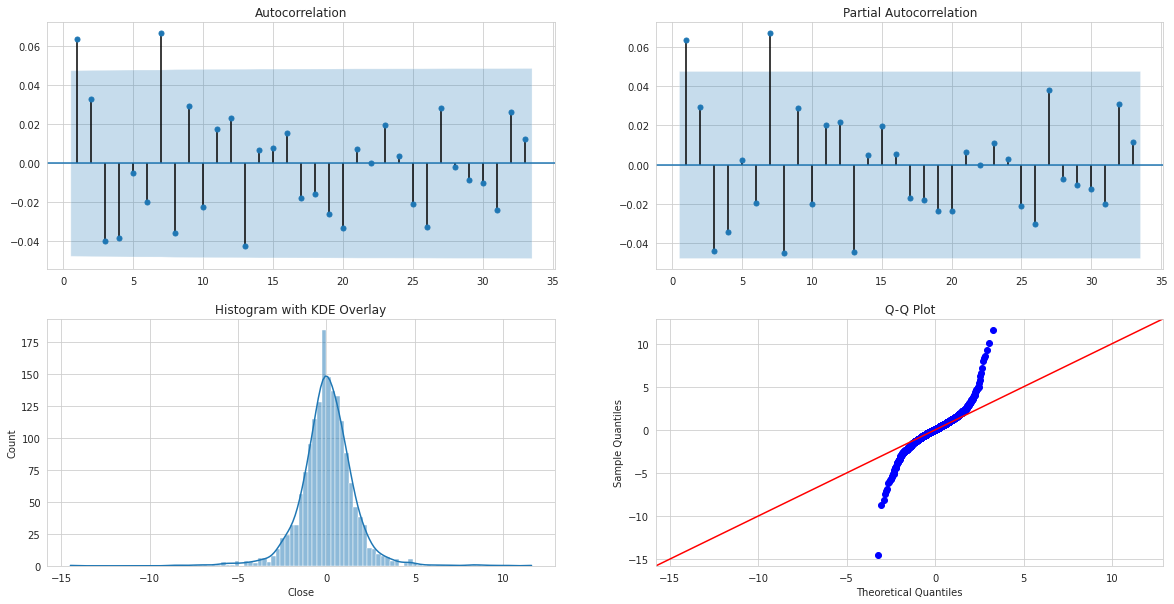

In [164]:
# Plot stationary graphs for base 10.

historicals_by_log = transform_by_log_returns(historicals, base=10)
plot_stationary_graphs(historicals_by_log['ETSY']['Close'])

###3. Outlier Seleciton

In [ ]:
# Choose the 2-sigma band or when should you choose your bands for outliers
# Or isolate for upward occurances or downward occurances

### Moving Averages

In [ ]:
# I think you forget to define what you can do here,
# We are looking for clear ways to cut and display black swan events
# Black swan events, defined by negative drops yes. Using a positive leaning system
# Are there giveaways in the sma or ema for these drops
# You can take the moving averages of this stock data

In [155]:
# No need to ma_shift
# Let's select changing sequence lengths
# and average over 30 days same for both ema and sma
# you can for loop it or intialize a numpy range with lambda map function
# np.apply_along_axis(indicators[inds], 1, norm_windows, ma_shift=ma_shift)
# But we still have to eda this shit along with zigzag here RIGHT NOW

historicals['AMD']

def calculate_sma(window, ma_shift):
  '''Calculates SMA for the given window and moving average shift.
  
  Equation for SMA given as: sum(past_closing_prices)/ma_shift.  
  
  Args:
    window: normalized window given as a numpy array.
    ma_shift: initial length that the indicator will see.
  
  Returns:
    sma_window: sma with sequence_length and moving average shift removed
  '''
  cumsum = np.cumsum(window)
  sma_window = (cumsum[(ma_shift-1):] - cumsum[:-(ma_shift-1)])/ma_shift
  return sma_window

def calculate_ema(window, ma_shift):
  '''Calculates EMA for the given window and moving average shift.
  
  Equation for EMA given as: current_closing_price x multiplier + EMA(previous_day) x (1-multiplier)
  Multiplier is fixed and given as 2/(ma_shift+1)
  If previous day's EMA is not available uses an initial SMA calculation to start.
  
  Args:
    window: normalized window given as a numpy array.
    ma_shift: initial length that the indicator will see.
  
  Returns:
    ema_window: ema with sequence_length and moving average shift removed
  '''
  multiplier = 2/(ma_shift+1)
  cumsum = np.cumsum(window[:ma_shift])
  ema_window = [cumsum[-1] / ma_shift]  # Create inital ema value
  for idx, current_price in enumerate(np.nditer(window[ma_shift:])):
    ema_window.append((current_price - ema_window[idx])*multiplier + ema_window[idx])
  return ema_window

In [ ]:
# Two log transformations to check here, base e and base 10

def transform_by_log_returns(historicals, base=math.e):
  '''Transforms historical ohlcv to their daily change percents.

  Daily percent changes are calculated by with the equation log(P2/P1)*100.
  Where P2 is the OHLCV data for the current day and P1 is the OHLCV data
  for the previous day, see "_calculate_daily_returns(ohlcv)."
  
  Args:
    historicals: dict with tickers as keys and values
                 as pandas dataframes.
    base: integer, {math.e, 10}. Defaults math.e.

  Returns:
    historicals_by_returns: dict with tickers as keys and values
                            as pandas dataframes.
  
  Raises:
    AssertionError: "Specified log base is not avaliable, please choose one {math.e, 10}."
  '''

  assert base in [math.e, 10], "Specified log base is not avaliable, please choose one {math.e, 10}."

  historicals_by_logs = {}
  for ticker, ohlcv in historicals.items():
    historicals_by_logs[ticker] = _calculate_log_returns(ohlcv, base)
  return historicals_by_logs

def _calculate_log_returns(ohlcv, base=10):
  '''Calculates log returns for the given stock history.'''
  log_returns = (ohlcv/ohlcv.shift(1))
  if base == math.e:
    log_returns = np.log(log_returns)*10
  else:
    log_returns = np.log10(log_returns)*100
  log_returns = log_returns.dropna()
  return log_returns

historicals_by_ln = transform_by_log_returns(historicals, base=math.e)
plot_stationary_graphs(historicals_by_ln['ETSY']['Close'])